In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt


The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


In [3]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name), 'r')


In [4]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0004274357358916608, 'norm': 0.09131797120370877, 'patient_id': 'dcfc3e70496246a709dab23831262b60589f4383d6e05bf5559731ea8d80bb1f'}


In [5]:
file_name = 'file_brain_AXFLAIR_200_6002447.h5'
hf = h5py.File(os.path.join(validation_path, file_name), 'r')


In [6]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.00041413615952341293, 'norm': 0.08723472457184536, 'patient_id': '30c14259008242f60e5214a793bad574fbf48a7140f76ec3152eef31e090486d'}


In [7]:
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
hf = h5py.File(os.path.join(test_path, file_name), 'r')


In [8]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'acquisition': 'AXFLAIR', 'num_low_frequency': 13, 'patient_id': 'ca18fce12f2549e69a2db3c660a4d27b116cd79c6ee2437a15db40db7379c723'}


In [9]:
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
hf = h5py.File(os.path.join(fully_sampled_test_path, file_name), 'r')


In [10]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0003919748921278401, 'norm': 0.08606309877132198, 'patient_id': '6002441'}


Here, we can test our preprocessing approach for training and validation data

In [26]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
preprocessed_train_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_train'
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'a') # Open in append mode!


In [27]:
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(kspace)))
print("Datatype of the raw kspace: ", str(type(kspace)))


Shape of the raw kspace:  (16, 20, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


In [28]:
# First, we need to create 2 masked versions of k-space:
#   - We need to estimate our sensitivity maps as if we have undersampled data with an ACS region (using ESPIRiT)
#   - We need an actual SENSE undersampling pattern for the actual reconstruction pipeline itself

from fastmri.data.subsample import EquispacedMaskFunc

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func) # For validation data we should pass a seed though!


In [29]:
print("Shape of the generated mask: ", str(mask_ACS.shape))
print("Datatype of the generated mask: ", str(type(mask_ACS)))


Shape of the generated mask:  torch.Size([1, 1, 1, 320, 1])
Datatype of the generated mask:  <class 'torch.Tensor'>


In [30]:
def generate_array(shape, R, tensor_out):
    length = shape[-1]

    # Initialize an array of zeros
    array = np.zeros(length)

    # Determine the central index
    array[length // 2] = 1

    # Set every R-1'th sample to 1, starting from the central index
    for i in range(length // 2, length, R):
        array[i] = 1

    # Mirror the behavior to the first half of the array
    if length % 2 == 0:
        array[1:length // 2] = np.flip(array[length // 2 + 1:])
    else:
        array[:length // 2] = np.flip(array[length // 2 + 1:])

    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)

    return array

mask = generate_array(kspace.shape, 4, tensor_out=False)
masked_kspace = kspace * mask + 0.0


In [31]:
print("Shape of the generated mask: ", str(mask.shape))
print("Datatype of the generated mask: ", str(type(mask)))


Shape of the generated mask:  (1, 1, 1, 320)
Datatype of the generated mask:  <class 'numpy.ndarray'>


In [39]:
# Now, let's preform a slice-wise ESPIRiT and CG-SENSE estimation

import bart

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def CG_SENSE(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CG-SENSE reconstruction, i.e. CS reconstruction with a regular l2 norm for which the objective function then corresponds to a SENSE reconstruction.
    https://colab.research.google.com/github/mrirecon/bart-workshop/blob/master/mri_together_2023/bart_mritogether_2023.ipynb#scrollTo=kNWQGBaX9ISp

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l2 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CG-SENSE reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CG-SENSE reconstruction
    reconstruction = bart.bart(1, 'pics -S -l2 -r {} -i {}'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction

sense_data = np.zeros((kspace.shape[0], kspace.shape[2], kspace.shape[3]), dtype=np.complex64)

for slice in range(kspace.shape[0]):
    S = estimate_sensitivity_maps(masked_kspace_ACS[slice,:,:,:])
    sense_data[slice,:,:] = CG_SENSE(masked_kspace[slice,:,:,:], S)

print("Shape of the numpy-converted sense data: ", str(sense_data.shape))
print("Type of the numpy-converted sense data: ", str(type(sense_data)))


Shape of the numpy-converted sense data:  (16, 640, 320)
Type of the numpy-converted sense data:  <class 'numpy.ndarray'>


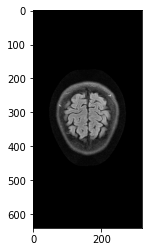

In [40]:
plt.imshow(np.abs(sense_data[10,:,:]), cmap='gray')


Here, we can test our preprocessing approach for test data

In [60]:
# R = 8
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
preprocessed_train_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test'
preprocessed_train_path_full = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full'


In [64]:
# First, find out what the value of R is
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'r') # Open in read mode!
nPE_mask = hf['mask'][()]
sampled_columns = np.sum(nPE_mask)
R = len(nPE_mask)/sampled_columns
R = float(R)
print(R)


8.0


In [66]:
# Also, use the official test scan ACS region for the sensitivity map estimation
masked_kspace_ACS = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(masked_kspace_ACS)))
print("Datatype of the raw kspace: ", str(type(masked_kspace_ACS)))


Shape of the raw kspace:  (16, 20, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


In [68]:
# Now, knowing R, create a SENSE kspace version from the scan's multicoil_test_full file
def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

hf = h5py.File(os.path.join(preprocessed_train_path_full, file_name), 'r') # Open in read mode!
kspace = hf['kspace'][()]
mask = generate_array(kspace.shape, closer_to_4_or_8(R), tensor_out=False)
masked_kspace = kspace * mask + 0.0


In [69]:
# Now, let's preform a slice-wise ESPIRiT and CG-SENSE estimation
sense_data = np.zeros((masked_kspace.shape[0], masked_kspace.shape[2], masked_kspace.shape[3]), dtype=np.complex64)

for slice in range(masked_kspace.shape[0]):
    S = estimate_sensitivity_maps(masked_kspace_ACS[slice,:,:,:])
    sense_data[slice,:,:] = CG_SENSE(masked_kspace[slice,:,:,:], S)

print("Shape of the numpy-converted sense data: ", str(sense_data.shape))
print("Type of the numpy-converted sense data: ", str(type(sense_data)))


Shape of the numpy-converted sense data:  (16, 640, 320)
Type of the numpy-converted sense data:  <class 'numpy.ndarray'>


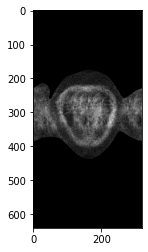

In [70]:
plt.imshow(np.abs(sense_data[10,:,:]), cmap='gray')


In [ ]:
# Write sense_data away
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'a') # Open in append mode!
# ...


In [71]:
# R = 4
file_name = 'file_brain_AXFLAIR_209_6001340.h5'


In [72]:
# First, find out what the value of R is
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'r') # Open in read mode!
nPE_mask = hf['mask'][()]
sampled_columns = np.sum(nPE_mask)
R = len(nPE_mask)/sampled_columns
R = float(R)
print(R)


4.0


In [73]:
# Also, use the official test scan ACS region for the sensitivity map estimation
masked_kspace_ACS = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(masked_kspace_ACS)))
print("Datatype of the raw kspace: ", str(type(masked_kspace_ACS)))


Shape of the raw kspace:  (16, 14, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


In [74]:
# Now, knowing R, create a SENSE kspace version from the scan's multicoil_test_full file
def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

hf = h5py.File(os.path.join(preprocessed_train_path_full, file_name), 'r') # Open in read mode!
kspace = hf['kspace'][()]
mask = generate_array(kspace.shape, closer_to_4_or_8(R), tensor_out=False)
masked_kspace = kspace * mask + 0.0


In [75]:
# Now, let's preform a slice-wise ESPIRiT and CG-SENSE estimation
sense_data = np.zeros((masked_kspace.shape[0], masked_kspace.shape[2], masked_kspace.shape[3]), dtype=np.complex64)

for slice in range(masked_kspace.shape[0]):
    S = estimate_sensitivity_maps(masked_kspace_ACS[slice,:,:,:])
    sense_data[slice,:,:] = CG_SENSE(masked_kspace[slice,:,:,:], S)

print("Shape of the numpy-converted sense data: ", str(sense_data.shape))
print("Type of the numpy-converted sense data: ", str(type(sense_data)))


Shape of the numpy-converted sense data:  (16, 640, 320)
Type of the numpy-converted sense data:  <class 'numpy.ndarray'>


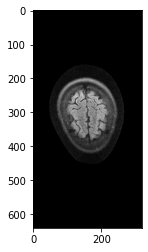

In [76]:
plt.imshow(np.abs(sense_data[10,:,:]), cmap='gray')


Here, we can test a loop which loops through the files in the folders we specify

In [57]:
from pathlib import Path

folder_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/'
files = Path(folder_path).glob('**/*')
for file in files:
    print(file)


/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT1POST_203_6000790.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_209_2090032.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_205_6000143.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_202_6000578.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_200_6002431.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_209_2090309.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_209_6001383.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_202_2020417.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_201_6002955.

In [79]:
from pathlib import Path

folder_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/'
files = Path(folder_path).glob('**/*')
for file in files:
    print(file.name)
    print('/folder/path/'+file.name)


file_brain_AXT1POST_203_6000790.h5
/folder/path/file_brain_AXT1POST_203_6000790.h5
file_brain_AXT2_209_2090032.h5
/folder/path/file_brain_AXT2_209_2090032.h5
file_brain_AXT2_205_6000143.h5
/folder/path/file_brain_AXT2_205_6000143.h5
file_brain_AXFLAIR_202_6000578.h5
/folder/path/file_brain_AXFLAIR_202_6000578.h5
file_brain_AXT2_200_6002431.h5
/folder/path/file_brain_AXT2_200_6002431.h5
file_brain_AXT2_209_2090309.h5
/folder/path/file_brain_AXT2_209_2090309.h5
file_brain_AXFLAIR_209_6001383.h5
/folder/path/file_brain_AXFLAIR_209_6001383.h5
file_brain_AXT2_202_2020417.h5
/folder/path/file_brain_AXT2_202_2020417.h5
file_brain_AXFLAIR_201_6002955.h5
/folder/path/file_brain_AXFLAIR_201_6002955.h5
file_brain_AXT2_208_2080716.h5
/folder/path/file_brain_AXT2_208_2080716.h5
file_brain_AXT2_200_2000498.h5
/folder/path/file_brain_AXT2_200_2000498.h5
file_brain_AXFLAIR_201_6003013.h5
/folder/path/file_brain_AXFLAIR_201_6003013.h5
file_brain_AXT2_203_2030129.h5
/folder/path/file_brain_AXT2_203_2030